In [3]:
#external packages
import numpy as np
import math
from astropy import units as u
import astropy.coordinates as coord
from astropy.table import Table
from astropy.io import fits
import time
from numpy.lib.recfunctions import append_fields
from astropy.cosmology import FlatLambdaCDM,Planck15
import sys

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

import sys
sys.path.append('/home/almhatre/data')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
#internal
from AGNclustering.kde import weighted_gaussian_kde
import AGNclustering.projected_correlation_functions as w
import AGNclustering.BASS_randoms as rand
from AGNclustering.utils import wp_d1d2,wp_dd

Assumes BASS catalog, galaxy catalogs, and sensitivity maps are in folder `data_directory'

## Initialize the cosmology
see here for reference: http://docs.astropy.org/en/stable/cosmology/

In [6]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

## Read in AGN catalog
From Swift/BAT AGN Spectroscopic Survey: Local, hard X-ray selected

In [7]:
data_directory = '/home/almhatre/data/BASS/'
cat = Table.read(data_directory + 'data_dr2.csv',format='csv')
agnt =np.array(cat)

List the names of the columns in the catalog. For the clustering code, you need at least 'ra', 'dec', and 'z'

In [8]:
agnt.dtype.names

('col0',
 'bat_index',
 'Counterpart',
 'Type',
 'z',
 'Mbh',
 'Method',
 'Edd_rat',
 'L_edd',
 'L_bol',
 'NH',
 'L210',
 'ra',
 'dec',
 'L14195',
 'AGN',
 'flux',
 'Snu_1',
 'Snu_6',
 'Morphology',
 'log_Ms',
 'Lir_sf')

Limit catalog to preferred luminosity & redshift range  
Here, we choose AGN with X-ray luminosities $>10^{42.5}$ erg/s, in the redshift range $0.01<z<0.1$:

In [9]:
agn = agnt[ (agnt['L210']>42.5) & (agnt['z']>.01)&(agnt['z']<=.1) ]

In [10]:
len(agn) #gives number of AGN in catalog (length of the array)

724

## Read in galaxy catalog

In [11]:
t = Table.read(data_directory +'2mrs_noAGN.csv',format='csv')
gal =np.array(t)

In [12]:
gal.dtype.names

('z', 'ra', 'dec', 'l', 'b', 'cdist')

In [13]:
gal=gal[(gal['z']>.01)&(gal['z']<=.1)] #Limit redshifts to same range as AGN
len(gal)

38567

## Plot positions of AGN, galaxies on the sky

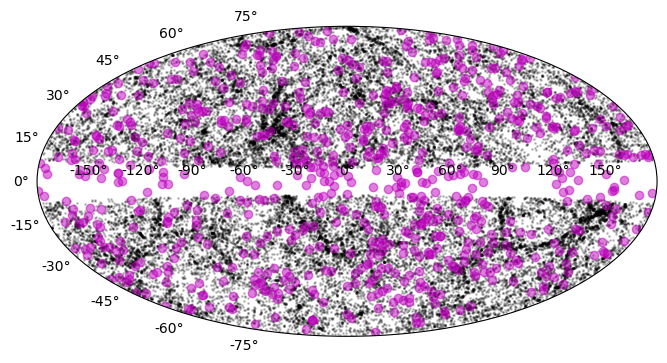

In [14]:
ra1 = coord.Angle(agn['ra']*u.degree)
ra1 = ra1.wrap_at(180*u.degree)
dec1 = coord.Angle(agn['dec']*u.degree)

ra2 = coord.Angle(gal['l']*u.degree)
ra2 = ra2.wrap_at(180*u.degree)
dec2 = coord.Angle(gal['b']*u.degree)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="aitoff")
#y1 = coord.Angle(8*u.degree)
#y2 = coord.Angle(-8*u.degree)

ax.scatter(ra2.radian, dec2.radian,1,color='k',alpha=.2)
ax.scatter(ra1.radian, dec1.radian,color='m',alpha=.5)


## Make random catalogs

Using sensitivity maps for 70 month survey


Set MJD-OBS to 53355.002572 from DATE-OBS.
Set MJD-END to 55469.117384 from DATE-END'. [astropy.wcs.wcs]


number of randoms: 56073


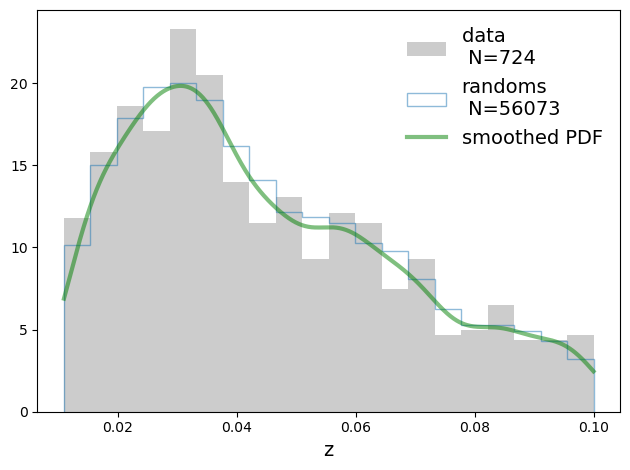

In [15]:
arand = rand.genrand(agn,100,cosmo,width=.2,scoords='galactic',use_BASS_sens_map=True,\
                     data_path=data_directory,plot=True,plot_filename=None)

#100: 100X randoms as AGN

In [16]:
arand.dtype.names

('z', 'ra', 'dec', 'l', 'b', 'flux', 'cdist')

number of randoms: 887041


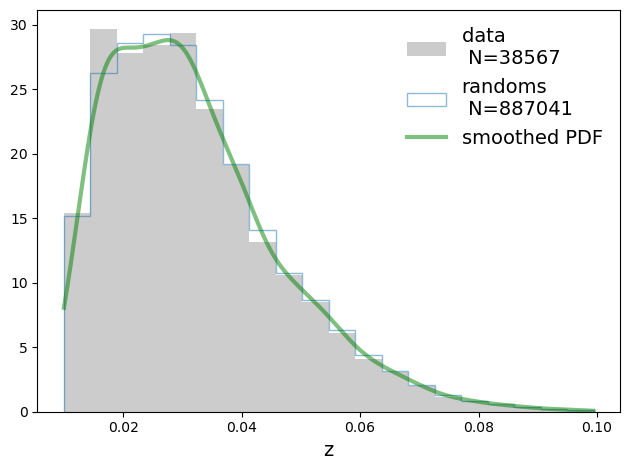

In [17]:
grandt = rand.genrand(gal,23,cosmo,width=.2,scoords='galactic',use_BASS_sens_map=False,\
                     plot=True,plot_filename=None)

# exclude galactic plane:
gal = gal[(gal['b']<-8) | (gal['b']>8)]
grand = grandt[(grandt['b']<-8) | (grandt['b']>8)]

## specify clustering parameters
pi_max: maximum seperation in redshift space that we integrate to (max length we average over)  
nbins: number of projected spatial bins

In [18]:
pimax=40
nbins = 10
bins = np.logspace(-1, np.log10(40), nbins + 1)

## Autocorrelate AGN

Using the Landy-Szalay estimator for the correlation function:   

$\xi(r_{p},\pi) = \frac{DD - 2DR + RR}{RR}$   
DD: # data-data pairs   
DR: # data-random pairs    
RR: # random-random pairs   

$w_{p} = 2 \int^{\pi_{\rm{max}}}_{0} \xi(r_{p},\pi) d\pi$

$r_p$: spatial separation perpendicular to the line of sight   
$\pi$: spatial separation parallel to the line of sight   

In [19]:
rp,wp_aa,wp_aa_err,cov = w.auto_wp(agn, arand, bins, pimax, 5, estimator='L')
# the 5 refers to the square root of the number of jackknife samples used to estimate the errors


using LCDM cosmology: Om0=.3, H0=70


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
Using AVX kernel
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.002 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.009 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.013 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.222 secs


Using  25  jacknife samples
1 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.016 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.205 secs


2 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.176 secs


3 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.190 secs


4 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.193 secs


5 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.012 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.178 secs


6 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.199 secs


7 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,16,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.012 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.009 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.215 secs


8 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.013 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.191 secs


9 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.009 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.207 secs


10 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.009 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.013 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.010 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.200 secs


11 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.013 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.205 secs


12 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.009 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.012 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.196 secs


13 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 16,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.012 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.188 secs


14 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.184 secs


15 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.002 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.195 secs


16 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.010 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.013 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.202 secs


17 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.012 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.204 secs


18 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,16,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.....100% done. Time taken =  0.004 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.016 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.009 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.203 secs


19 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.194 secs


20 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.012 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.200 secs


21 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%........100% done. Time taken =  0.012 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.200 secs


22 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.012 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.009 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.221 secs


23 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.012 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.195 secs


24 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.012 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........

25 / 25


100% done. Time taken =  0.193 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.012 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.205 secs


Plot

Text(0.5, 1.0, 'AGN ACF')

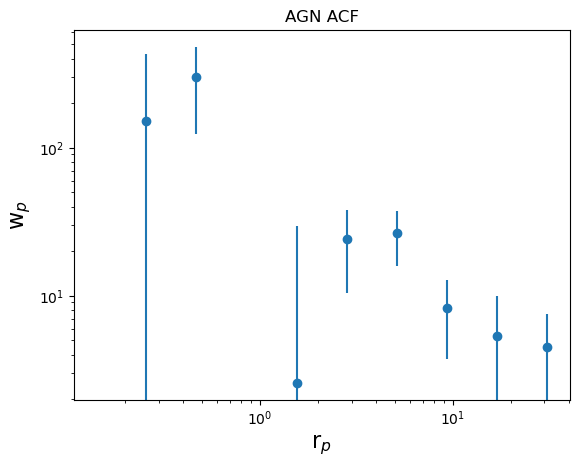

In [20]:
plt.yscale("log")
plt.xscale("log")
plt.errorbar(rp,wp_aa,yerr=wp_aa_err,fmt='o')
plt.xlabel('r$_{p}$',fontsize=16)
plt.ylabel('w$_{p}$',fontsize=16)
plt.title('AGN ACF')

There's a signal, but the errors are pretty large

## Cross-correlate AGN with galaxies

$\xi(r_{p},\pi) = \frac{D_{1}D_{2} - D_{1}R_{2} - D_{2}R_{1} + R_{1}R_{2}}{R_{1}R_{2}}$   

1: AGN   
2: Galaxies

In [22]:
t1=time.time()
rp,wp_ag,wp_ag_err,Mag,zp_ag = w.cross_wp(d1=agn, d2=gal, r1=arand, r2=grand, bins=bins, pimax=pimax, m=5, estimator='L')
t = time.time() - t1

using LCDM cosmology: Om0=.3, H0=70


/home/almhatre/data/AGNclustering/error.py:137: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if r1blocks is not 0:
/home/almhatre/data/AGNclustering/error.py:142: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if r1blocks is not 0:
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.012 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.096 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.107 secs
In gri

Using  25  jacknife samples
1 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.054 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.094 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

2 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.052 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.088 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%......

3 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.049 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.104 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

4 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.086 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

5 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.049 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.103 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

6 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.048 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.103 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

7 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.047 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.098 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

8 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,19,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.101 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

9 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.088 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

10 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.102 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%......

11 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.049 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.103 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

12 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.094 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%......

13 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.050 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.084 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

14 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.093 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%......

15 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.096 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

16 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.049 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.104 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

17 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.092 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%......

18 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,19,10.  Time taken =   0.037 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.088 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%......

19 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.049 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.099 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

20 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.090 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%......

21 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.048 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.103 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

22 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.101 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%......

23 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.096 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%......

24 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.088 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

25 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.093 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

In [23]:
print('took ',str(t/60),' minutes')

took  2.8827277421951294  minutes


Text(0.5, 1.0, 'AGN XCF')

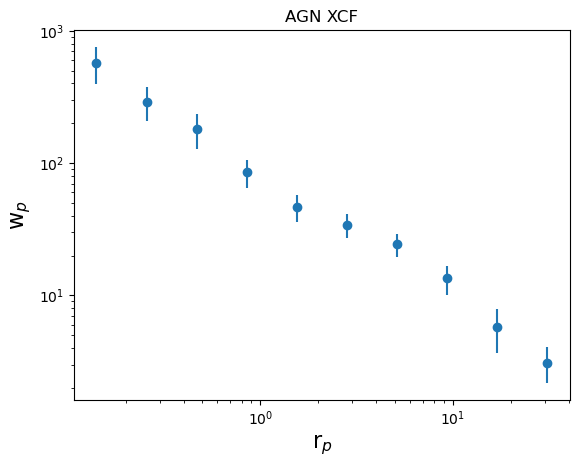

In [24]:
plt.yscale("log")
plt.xscale("log")
plt.errorbar(rp,wp_ag,yerr=wp_ag_err,fmt='o')
plt.xlabel('r$_{p}$',fontsize=16)
plt.ylabel('w$_{p}$',fontsize=16)
plt.title('AGN XCF')

better!

Try another estimator (Davis & Peebles):
$\xi(r_{p},\pi) = \frac{D_{1}D_{2}}{D_{1}R_{2}} - 1$   

In [25]:
#%%timeit
t1=time.time()
rp,wp_agp,wp_agp_err,Mag,zp_agp = w.cross_wp(d1=agn, d2=gal, r1=arand, r2=grand, bins=bins, pimax=pimax, m=5, estimator='P')
t = time.time() - t1

using LCDM cosmology: Om0=.3, H0=70


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.065 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.107 secs


Using  25  jacknife samples
1 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.056 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.104 secs


2 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.095 secs


3 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.094 secs


4 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.045 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.099 secs


5 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.046 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.103 secs


6 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.103 secs


7 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.098 secs


8 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,19,10.  Time taken =   0.047 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.097 secs


9 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.048 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.096 secs


10 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.104 secs


11 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.044 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.103 secs


12 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.093 secs


13 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.038 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.083 secs


14 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.085 secs


15 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.103 secs


16 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.103 secs


17 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.109 secs


18 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,19,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.093 secs


19 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.089 secs


20 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.092 secs


21 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.051 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.114 secs


22 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.048 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.098 secs


23 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.045 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.100 secs


24 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.009 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%......100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.089 secs


25 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.093 secs


In [26]:
print('took ',str(t),' seconds')

took  10.120978832244873  seconds


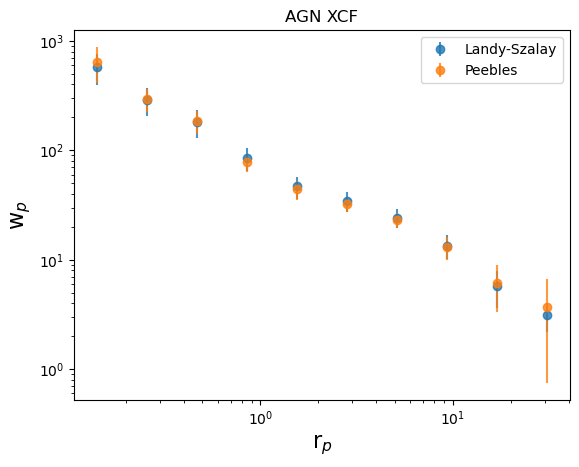

In [62]:
plt.yscale("log")
plt.xscale("log")
plt.errorbar(rp,wp_ag,yerr=wp_ag_err,fmt='o',label='Landy-Szalay',alpha=0.8)
plt.errorbar(rp,wp_agp,yerr=wp_agp_err,fmt='o',label='Peebles',alpha=0.8)
plt.xlabel('r$_{p}$',fontsize=16)
plt.ylabel('w$_{p}$',fontsize=16)
plt.title('AGN XCF')
plt.legend()

In [64]:
# Collapsing 2d correlation function along rp and graphing wp(zp)


#%%timeit
t1=time.time()
rp,wp_agp,wp_agp_err,Mag,zp_lgp = w.cross_wp(d1=agn, d2=gal, r1=arand, r2=grand, bins=bins, pimax=pimax, m=5, estimator='P')
t = time.time() - t1

using LCDM cosmology: Om0=.3, H0=70


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.066 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.108 secs


Using  25  jacknife samples
1 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.102 secs


2 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.095 secs


3 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.046 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.092 secs


4 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.046 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.095 secs


5 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.048 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.103 secs


6 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.107 secs


7 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.050 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.109 secs


8 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,19,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.095 secs


9 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.100 secs


10 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.103 secs


11 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.051 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.115 secs


12 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%100% done. Time taken =  0.097 secs


13 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.048 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.103 secs


14 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.090 secs


15 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.100 secs


16 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.101 secs


17 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.089 secs


18 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,19,10.  Time taken =   0.046 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.096 secs


19 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.038 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.087 secs


20 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.101 secs


21 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.101 secs


22 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.046 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.099 secs


23 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.046 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.094 secs


24 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.091 secs


25 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.101 secs


In [65]:
print('took ',str(t),' seconds')

took  10.1016263961792  seconds


Text(0.5, 1.0, 'Scatter Plot of Unit width Binned z-shift')

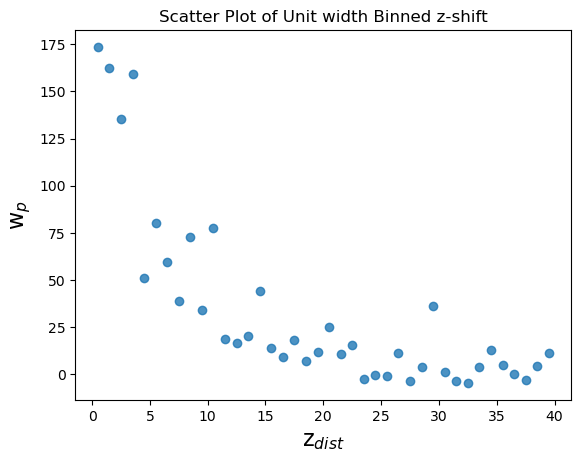

In [70]:
# Graphing Wp(zp) with unit width binning zp

zbins = np.arange(.5,40.5,1)

plt.scatter(zbins,zp_agp,alpha=0.8)
plt.xlabel('z$_{dist}$',fontsize=16, )
plt.ylabel('w$_{p}$',fontsize=16)
plt.title('Scatter Plot of Unit width Binned z-shift')

[ 0.5  1.5  3.   6.5 14.  29.5]
[173.61761913 162.59892711 294.54215993 301.83293009 259.20088267
 132.98949641]
[173.61761913 162.59892711 135.54408157 158.99807836  50.80410739
  80.28517845  59.46534807  38.57657407  72.7017221   34.25445479
  77.66865852  18.70011135  16.30466098  20.17585574  44.10138416
  13.92223198   8.95737121  18.3821652    6.73398874  11.73224652
  25.08667398  10.58854615  15.22328224  -2.43238352  -0.59619205
  -1.22474346  11.48067192  -3.83928656   3.75820291  36.35251781
   1.14726598  -3.42478621  -4.63623616   3.76033122  12.59075049
   4.92191754   0.17706686  -3.05610571   4.19954062  11.18021585]
[ 1  2  4  9 19 40]


Text(0.5, 1.0, 'Scatter Plot of Logaritmically Binned z-shift')

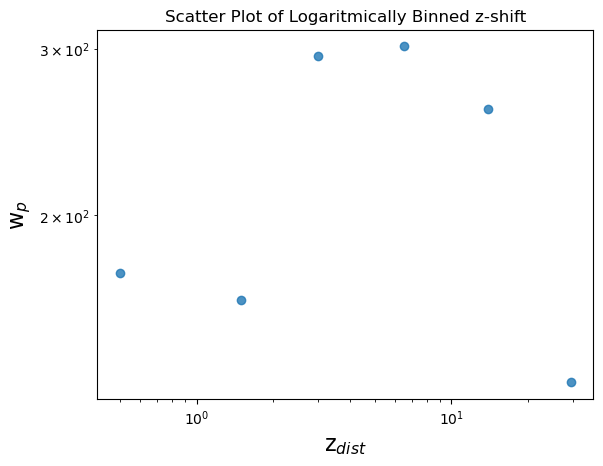

In [73]:
#Graphin Wp(zp) binning zp logarithimically

zbins = np.logspace(0,np.log10(40),6, dtype=int)


zp_binned = np.zeros(len(zbins))
for i in range(len(zbins)):
    if i==0:
        for j in range(0,zbins[i]):
            zp_binned[0] = zp_binned[0] + zp_agp[j]
    else:
        for j in range(zbins[i-1],zbins[i]):
            zp_binned[i] = zp_binned[i] + zp_agp[j]

zaxis = np.empty((len(zbins)))
for i in range (len(zbins)):
    if i == 0:
        zaxis[0]= 0 + (zbins[i])/2
    else:
        zaxis[i] = zbins[i-1] + (zbins[i]-zbins[i-1])/2
        
print(zaxis)
print(zp_binned)
print(zp_agp)
print(zbins)
plt.yscale("log")
plt.xscale("log")
plt.scatter(zaxis,zp_binned,alpha=0.8)
plt.xlabel('z$_{dist}$',fontsize=16, )
plt.ylabel('w$_{p}$',fontsize=16)
plt.title('Scatter Plot of Logaritmically Binned z-shift')

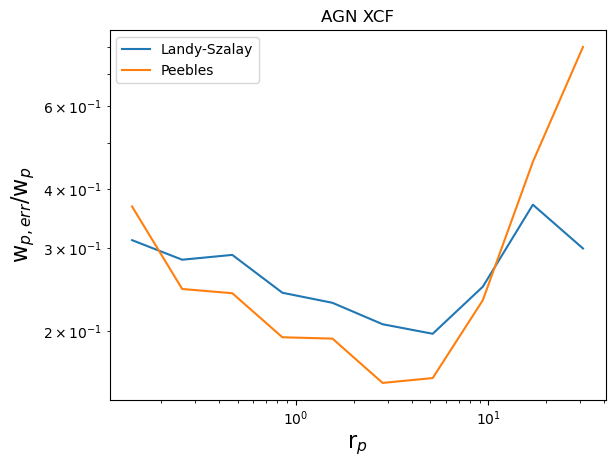

In [74]:
plt.yscale("log")
plt.xscale("log")
plt.plot(rp,wp_ag_err/wp_ag,label='Landy-Szalay')
plt.plot(rp,wp_agp_err/wp_agp,label='Peebles')
plt.xlabel('r$_{p}$',fontsize=16)
plt.ylabel('w$_{p,err}$/w$_{p}$',fontsize=16)
plt.title('AGN XCF')
plt.legend()